In [1]:
# Module Imports
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt, mpl

In [2]:
# Seed & Graph settings
np.random.seed(1000)
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

# Kelly Criterion Example w Coin Tossing

In [5]:
# p = probability of heads
p = 0.55
# the difference between heads and tails odds.
# optimal investment ratio
f = p - (1-p)
f

0.10000000000000009

In [6]:
# number of series
I = 50
# number of coin tosses
n = 100

In [12]:
def run_simulation(f):
    # Instatiate ndarray to store simulation results
    c = np.zeros((n, I))
    # Initializes the starting capital with 100
    c[0] = 100
    # Outter loop for series simulations
    for i in range(I):
        #Inner loop for series itself
        for t in range(1, n):
            # Simulates tossing a coin
            o = np.random.binomial(1, p)
            # If 1 or Heads -- add win to capital
            if o > 0:
                c[t, i] = (1 + f) * c[t - 1, i]
            # If 0 or Tails -- subtract the loss from the capital
            else:
                c[t, i] = (1 - f) * c[t - 1, i]
                
    return c

In [13]:
# Run the simulation
c_1 = run_simulation(f)

In [14]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [110.  ,  90.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [121.  ,  99.  ,  81.  , ...,  99.  ,  81.  , 121.  ],
       ...,
       [413.27,  45.46, 617.35, ..., 185.2 , 226.35, 413.27],
       [454.6 ,  40.91, 555.62, ..., 203.72, 203.72, 454.6 ],
       [500.06,  45.  , 500.06, ..., 224.09, 183.34, 500.06]])

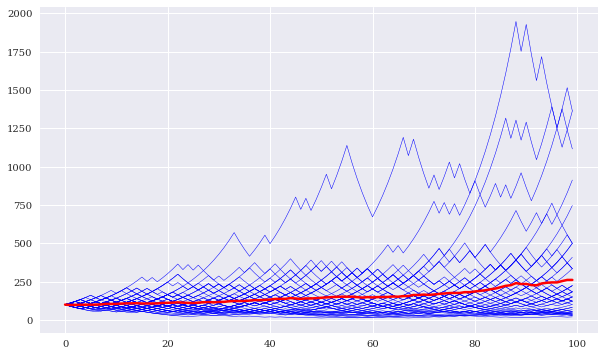

In [15]:
plt.figure(figsize=(10,6))
# Plot all 50 series
plt.plot(c_1, 'b', lw=0.5)
# Plot avg of 50 series
plt.plot(c_1.mean(axis=1), 'r', lw=2.5)

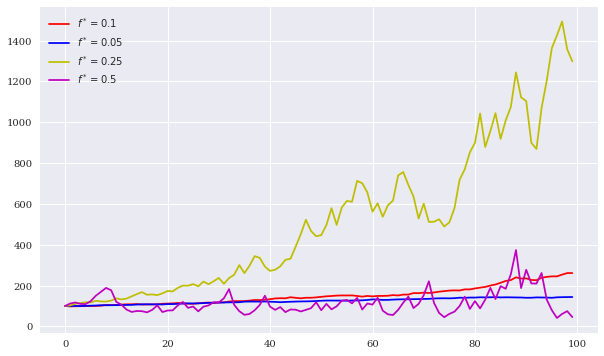

In [20]:
# Let's repeat the simulation for different values of f
# Lower fractions lead to lower growth rate
# Increasing F increases the volatility

c_2 = run_simulation(0.05)
c_3 = run_simulation(0.25)
c_4 = run_simulation(0.5)

plt.figure(figsize=(10,6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f^*=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f^*=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f^*=0.5$')
plt.legend(loc=0)

# Kelly Criterion on Stocks and Indices

In [26]:
# Pull data CSV, choose symbol, create DF, drop NAs, and look at tail
raw = pd.read_csv("http://hilpisch.com/pyalgo_eikon_eod_data.csv",
                 index_col=0, parse_dates=True)

symbol = '.SPX'

data = pd.DataFrame(raw[symbol])

data['return'] = np.log(data / data.shift(1))

data.dropna(inplace=True)

data.tail()

,.SPX,return
Date,,
2019-12-23,3224.01,0.000866
2019-12-24,3223.38,-0.000195
2019-12-27,3240.02,0.000034
2019-12-30,3221.29,-0.005798
2019-12-31,3230.78,0.002942


In [28]:
# "Everything being equal, the Kelly Criterion implies a higher leverage when expected return is higher than volatility"

# Annualized Return
mu = data['return'].mean() * 252

# Annualized Volatility
sigma = data['return'].std() * 252 ** 0.5

# Set Risk-Free ratio
r = 0.0

# Optimal Kelly fraction to be invested into the strategy
f = (mu - r) / sigma ** 2

f

4.585590244019799

In [29]:
# Now, let's simulat the application & optimal leverage ratio
# Initial Equity set to 1
# Total capital itself is adjusted daily, according to available equity
# Loss = Capital Reduced, Win = Capital Incr.

equs = []

def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    # New column for Equ, set at init value 1
    data[equ] = 1
    # New column for capital, set at init value of 1 * f^*
    data[cap] = data[equ] * f
    for i, t in enumerate(data.index[1:]):
        # Picks the right DateTimeIndex value for the previous values
        t_1 = data.index[i]
        # New capital position, given the return
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['return'].loc[t])
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
        # Adjust equity value, given capital position performance
                            data[equ].loc[t_1]
        # Adjust capital position, given new equity position & fixed leverage ratio
        data.loc[t, cap] = data[equ].loc[t] * f

In [30]:
kelly_strategy(f * 0.5)

In [31]:
kelly_strategy(f * 0.66)

In [32]:
kelly_strategy(f)

In [33]:
# Quick look at DF
print(data[equs].tail())

            equity_2.29  equity_3.03  equity_4.59
Date                                             
2019-12-23     6.628865     9.585294    14.205748
2019-12-24     6.625895     9.579626    14.193019
2019-12-27     6.626410     9.580610    14.195229
2019-12-30     6.538582     9.412991    13.818934
2019-12-31     6.582748     9.496919    14.005618


<AxesSubplot:xlabel='Date'>

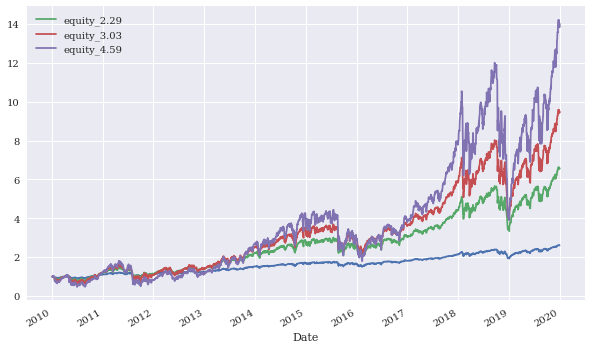

In [34]:
ax = data['return'].cumsum().apply(np.exp).plot(figsize=(10,6))
data[equs].plot(ax=ax, legend=True)

# Vectorized Backtesting on Oanda

In [35]:
import tpqoa

%time api = tpqoa.tpqoa('algo.cfg')

Wall time: 8 ms


In [40]:
instrument = 'EUR_USD'

raw = api.get_history(instrument,
                     start='2020-06-08',
                     end='2020-06-13',
                     granularity='M10',
                     price='M')

raw.tail()

,o,h,l,c,volume,complete
time,,,,,,
2020-06-12 20:10:00,1.12572,1.12593,1.12532,1.12568,221,True
2020-06-12 20:20:00,1.12569,1.12578,1.12532,1.12558,163,True
2020-06-12 20:30:00,1.12560,1.12573,1.12534,1.12543,192,True
2020-06-12 20:40:00,1.12544,1.12594,1.12528,1.12542,219,True
2020-06-12 20:50:00,1.12544,1.12624,1.12541,1.12554,296,True


<AxesSubplot:xlabel='time'>

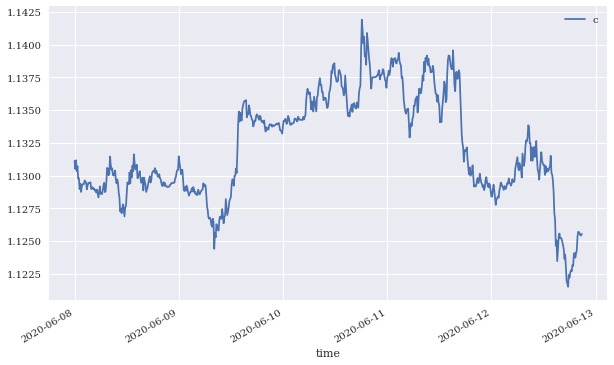

In [41]:
# Specifying the average bid-ask spread as proportional transaction costs
spread = 0.00012
# Mean closing price for the data set
mean = raw['c'].mean()
# Calculates the average proportional transaction costs given the average spread
# and the average mid closing price
ptc = spread / mean

raw['c'].plot(figsize=(10,6), legend=True)

### Creating features and labels data

In [42]:
# Setting up Data & Lags, from which the ML Algo will learn

data = pd.DataFrame(raw['c'])

data.columns = [instrument,]

window = 20

data['return'] = np.log(data / data.shift(1))
# Calculates Volatility
data['vol'] = data['return'].rolling(window).std()
# Derives momentum as the mean of recent log returns
data['mom'] = np.sign(data['return'].rolling(window).mean())
# Calculates SMA
data['sma'] = data[instrument].rolling(window).mean()
# Calculates rolling min
data['min'] = data[instrument].rolling(window).min()
# Calculates rolling max
data['max'] = data[instrument].rolling(window).max()

# Quick clean up
data.dropna(inplace=True)

lags = 6

features = ['return','vol','mom','sma','min','max']

# Adding lagged feature data to DataFrame
cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = f'{f}_lag_{lag}'
        data[col] = data[f].shift(lag)
        cols.append(col)
        
# Quick clean up
data.dropna(inplace=True)

# Defining labels data as the market direction with 1 UP or -1 DOWN
data['direction'] = np.where(data['return'] > 0, 1, -1)

### Implementing Classification Algorithms & Machine Learning

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
# The 
from sklearn.ensemble import AdaBoostClassifier

AttributeError: module 'importlib._bootstrap' has no attribute 'SourceFileLoader'